# Library and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, \
                            classification_report, f1_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from collections import Counter, defaultdict
import nltk
import nltk as nlp
import string
import re


Using TensorFlow backend.


In [2]:
true = pd.read_csv(r"E:\UMT\S6\Data Science\Project\Data\FakeNews-training.csv")
fake = pd.read_csv(r"E:\UMT\S6\Data Science\Project\Data\FakeNews-testing.csv")

# Reading Data

In [3]:
fake['target'] = 'fake'
true['target'] = 'true'
newstot = pd.concat([fake, true]).reset_index(drop = True)
newstot.head()

,Id,title,text,subject,date,label,target
0,22216,Five killed in sectarian attack in Pakistan,"QUETTA, Pakistan (Reuters) - (This October 9 s...",worldnews,"October 9, 2017",0,fake
1,27917,White House narrows search to three for Suprem...,"WASHINGTON/AUSTIN, Texas (Reuters) - The White...",politicsNews,"March 11, 2016",0,fake
2,25007,THE DEATH OF P.C. POLICE? Trump’s DOJ Makes Ma...,The Justice Department on Thursday dropped the...,politics,"Jun 30, 2017",1,fake
3,1377,"House, Senate Republicans face challenge over ...",WASHINGTON (Reuters) - U.S. Republicans in Con...,politicsNews,"December 5, 2017",0,fake
4,32476,China complains about Taiwan content in U.S. d...,BEIJING (Reuters) - China said on Thursday it ...,worldnews,"December 14, 2017",0,fake


In [4]:
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")

print(f"Total Records:\t{fake.shape[0]}")

politicsNews:	3409
worldnews:	3057
News:	2672
politics:	2009
left-news:	1363
Government News:	481
Middle-east:	242
US_News:	237
Total Records:	13470


In [5]:
for key,count in true.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")

    print(f"Total Records:\t{true.shape[0]}")

politicsNews:	7863
Total Records:	31428
worldnews:	7088
Total Records:	31428
News:	6378
Total Records:	31428
politics:	4832
Total Records:	31428
left-news:	3096
Total Records:	31428
Government News:	1089
Total Records:	31428
US_News:	546
Total Records:	31428
Middle-east:	536
Total Records:	31428


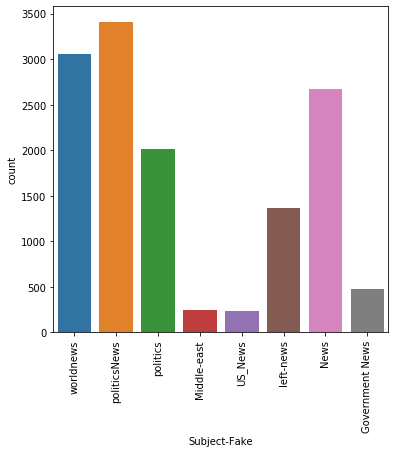

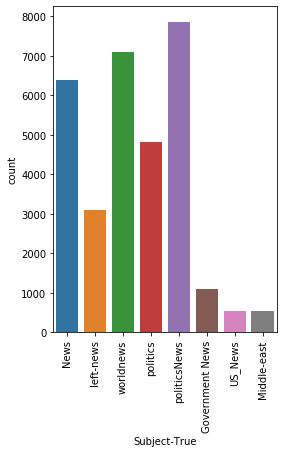

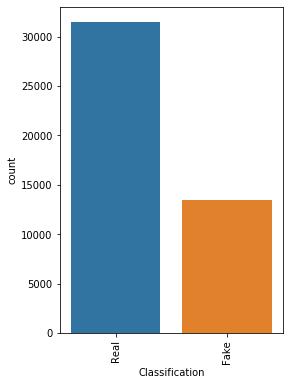

In [6]:
fake['fake'] = 1
true['fake'] = 0

data_df = pd.concat([fake, true], ignore_index=True)

plt.figure(figsize=(6,6))
sns.countplot("subject", data=fake)
plt.xticks(rotation=90)
plt.xlabel('Subject-Fake')
plt.show()

plt.figure(figsize=(4,6))
sns.countplot("subject", data=true)
plt.xticks(rotation=90)
plt.xlabel('Subject-True')
plt.show()

plt.figure(figsize=(4,6))
ax = sns.countplot(x="fake", data=data_df)
ax.set_xticklabels(['Real', 'Fake'])
plt.xlabel('Classification')
plt.xticks(rotation=90)
plt.show()

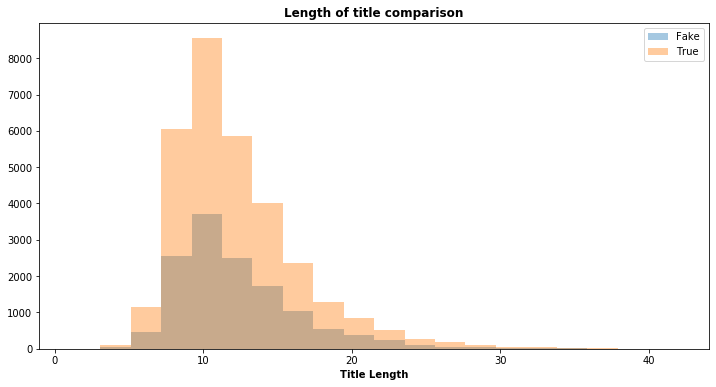

In [7]:
data_df['title_length'] = data_df['title'].apply(lambda x : len(x.strip().split()))
data_df['text_length'] = data_df['text'].apply(lambda x : len(x.strip().split()))

plt.figure(figsize=(12,6))
sns.distplot(data_df[data_df['fake'] == 1]['title_length'], 
             kde=False, label='Fake', bins=20)
sns.distplot(data_df[data_df['fake'] == 0]['title_length'], 
             kde=False, label='True', bins=20)
plt.xlabel('Title Length', weight='bold')
plt.title('Length of title comparison', weight='bold')
plt.legend()
plt.show()

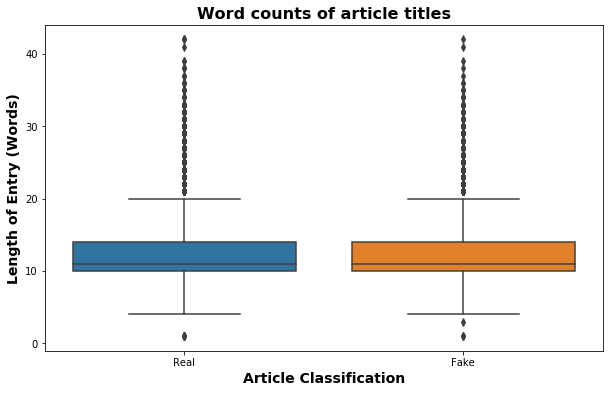

In [8]:
fig = plt.figure(figsize=(10, 6))
plt.title("Word counts of article titles", fontsize=16, weight='bold')
ax = sns.boxplot(x="fake", y="title_length", data=data_df)
ax.set_xticklabels(['Real', 'Fake'])
ax.set_xlabel("Article Classification", fontsize=14, weight='bold') 
ax.set_ylabel("Length of Entry (Words)", fontsize=14, weight='bold')
plt.show()

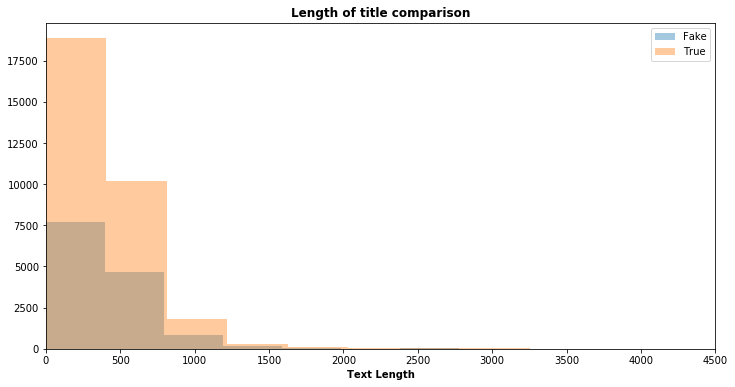

In [9]:
plt.figure(figsize=(12,6))
sns.distplot(data_df[data_df['fake'] == 1]['text_length'], 
             kde=False, label='Fake', bins=20)
sns.distplot(data_df[data_df['fake'] == 0]['text_length'], 
             kde=False, label='True', bins=20)
plt.xlabel('Text Length', weight='bold')
plt.title('Length of title comparison', weight='bold')
plt.xlim(0.0, 4500)
plt.legend()
plt.show()

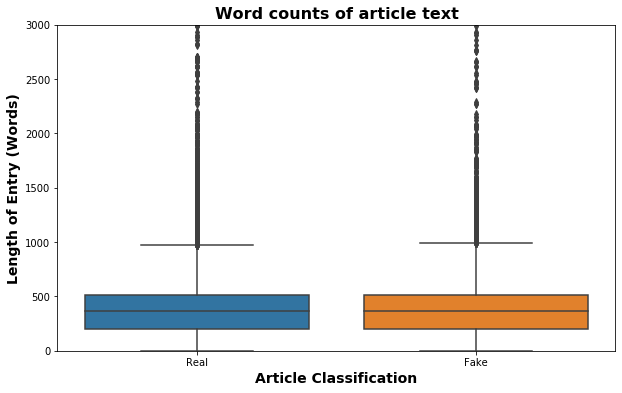

In [10]:
fig = plt.figure(figsize=(10, 6))
plt.title("Word counts of article text", fontsize=16, weight='bold')
ax = sns.boxplot(x="fake", y="text_length", data=data_df)
ax.set_xticklabels(['Real', 'Fake'])
ax.set_xlabel("Article Classification", fontsize=14, weight='bold') 
ax.set_ylabel("Length of Entry (Words)", fontsize=14, weight='bold')
plt.ylim(0.0, 3000.0)
plt.show()

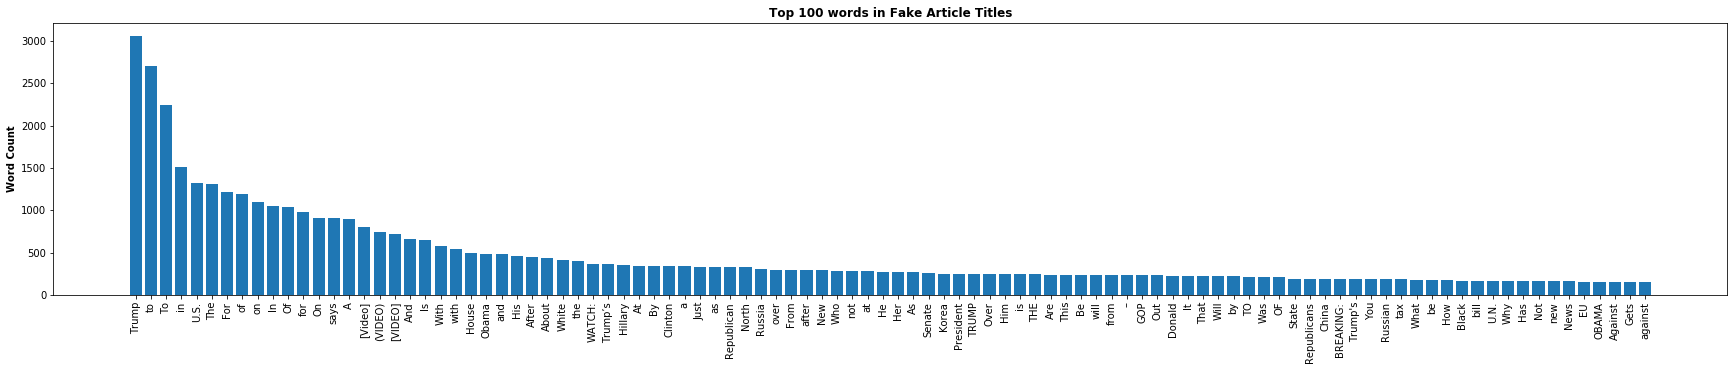

Total unique words in title: 30673


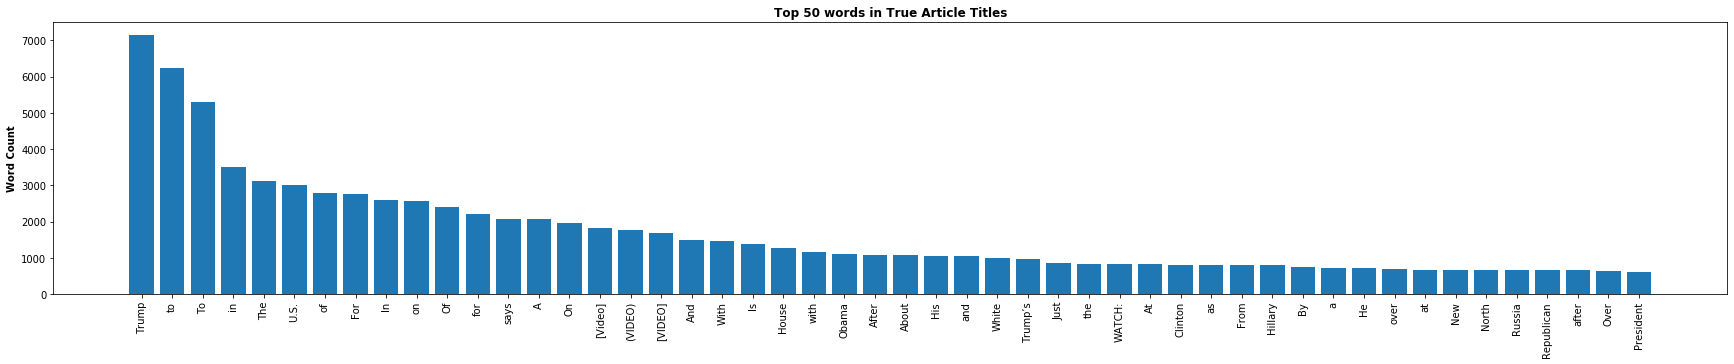

Total unique words in title: 48026


In [11]:
def create_corpus(text_data):
    corpus = []
    for sentence in text_data:
        for word in sentence.split():
            corpus.append(word)
    return corpus
            
def top_words(text_corpus, top_n=25, return_dict=False):
    def_dict = defaultdict(int)
    for word in text_corpus:
        def_dict[word] += 1
    most_common = sorted(def_dict.items(), key=lambda x : x[1], reverse=True)[:top_n]
    if return_dict:
        return most_common, def_dict
    else:    
        return most_common
    
top_n = 100
text_field = "title"

fake_corpus = create_corpus(fake[text_field].values)
fake_top_n_words, fake_symptom_dict = top_words(fake_corpus, top_n=top_n, return_dict=True)
fake_words, fake_word_counts = zip(*fake_top_n_words)

def plot_words(word_list, word_counts, n, text_description, figsize=(30,5)):
    plt.figure(figsize=figsize)
    plt.xticks(rotation=90)
    plt.bar(word_list, word_counts)
    plt.title(f"Top {n} words in {text_description}", weight='bold')
    plt.ylabel("Word Count", weight='bold')
    plt.show()

plot_words(fake_words, fake_word_counts, 100, "Fake Article Titles")
print(f"Total unique words in {text_field}: {len(fake_symptom_dict)}")

top_n = 50
text_field = "title"

true_corpus = create_corpus(true[text_field].values)
true_top_n_words, true_symptom_dict = top_words(true_corpus, top_n=top_n, return_dict=True)
true_words, true_word_counts = zip(*true_top_n_words)

plot_words(true_words, true_word_counts, 50, "True Article Titles")
print(f"Total unique words in {text_field}: {len(true_symptom_dict)}")


In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_y, pred_y, title='Confusion Matrix', figsize=(8,6)):

    conf_matrix = confusion_matrix(true_y, pred_y)
    conf_df = pd.DataFrame(conf_matrix, columns=np.unique(true_y), index = np.unique(true_y))
    conf_df.index.name = 'Actual'
    conf_df.columns.name = 'Predicted'
    plt.figure(figsize = figsize)
    plt.title(title)
    sns.set(font_scale=1.4)
    sns.heatmap(conf_df, cmap="Blues", annot=True, 
                annot_kws={"size": 16}, fmt='g')
    plt.show()

# Logistic Regression Classifier

In [13]:
x_train,x_test,y_train,y_test = train_test_split(newstot['text'], newstot.target, test_size=0.2, random_state=2020)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model_log = pipe.fit(x_train, y_train)
prediction = model_log.predict(x_test)
acc_LG = round(model_log.score(x_train, y_train)*80,20)
acc_LG

C:\Users\alina\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


56.94303691742302

Samples incorrectly classified: 2758 out of 8980.
Logistic Regression classifier accuracy: 56.94%


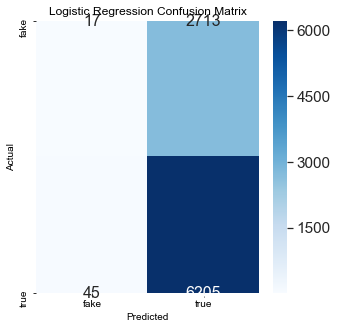

              precision    recall  f1-score   support

        fake       0.27      0.01      0.01      2730
        true       0.70      0.99      0.82      6250

    accuracy                           0.69      8980
   macro avg       0.48      0.50      0.42      8980
weighted avg       0.57      0.69      0.57      8980



In [14]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Logistic Regression classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Logistic Regression Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [15]:
from sklearn.metrics import f1_score
f1_LG = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_LG)

F1 score: 0.573141


# Support Vector Classifier

In [16]:
x_train,x_test,y_train,y_test = train_test_split(newstot['text'], newstot.target, test_size=0.2, random_state=2020)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model_SVC = pipe.fit(x_train, y_train)
prediction = model_SVC.predict(x_test)
acc_SVC = round(model_SVC.score(x_train, y_train)*80,20)
acc_SVC

68.34901720585779

Samples incorrectly classified: 3215 out of 8980.
SVC classifier accuracy: 56.94%


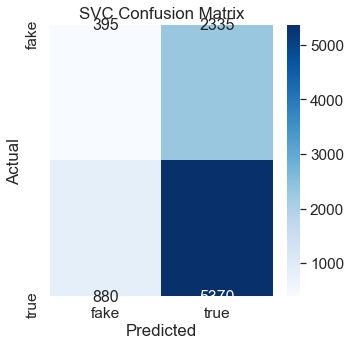

              precision    recall  f1-score   support

        fake       0.31      0.14      0.20      2730
        true       0.70      0.86      0.77      6250

    accuracy                           0.64      8980
   macro avg       0.50      0.50      0.48      8980
weighted avg       0.58      0.64      0.60      8980



In [17]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("SVC classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="SVC Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [18]:
from sklearn.metrics import f1_score
f1_SVC = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_SVC)

F1 score: 0.595613


# Multinomial Naive Bayes Classifier

In [19]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model_MNB = pipe.fit(x_train, y_train)
prediction = model_MNB.predict(x_test)
acc_MNB = round(model_MNB.score(x_train, y_train)*80,20)
acc_MNB

56.08998273845983

Samples incorrectly classified: 2730 out of 8980.
Multinomial Naive Bayes classifier accuracy: 56.94%


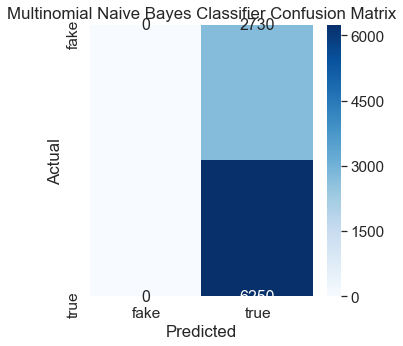

C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        fake       0.00      0.00      0.00      2730
        true       0.70      1.00      0.82      6250

    accuracy                           0.70      8980
   macro avg       0.35      0.50      0.41      8980
weighted avg       0.48      0.70      0.57      8980



In [20]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Multinomial Naive Bayes classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Multinomial Naive Bayes Classifier Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [21]:
from sklearn.metrics import f1_score
f1_MNB = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_MNB)

F1 score: 0.571234


C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Bernoulli Naive Bayes Classifier

In [22]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', BernoulliNB())])

model_BNB = pipe.fit(x_train, y_train)
prediction = model_BNB.predict(x_test)
acc_BNB = round(model_BNB.score(x_train, y_train)*80,20)
acc_BNB

64.01024555932959

Samples incorrectly classified: 3092 out of 8980.
Barnoulli Naive Bayes classifier accuracy: 56.94%


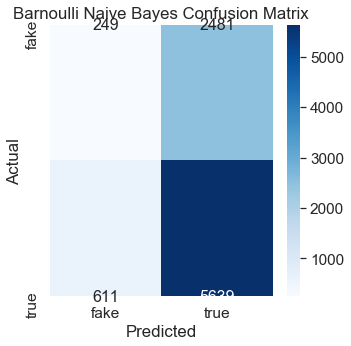

              precision    recall  f1-score   support

        fake       0.29      0.09      0.14      2730
        true       0.69      0.90      0.78      6250

    accuracy                           0.66      8980
   macro avg       0.49      0.50      0.46      8980
weighted avg       0.57      0.66      0.59      8980



In [23]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Barnoulli Naive Bayes classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Barnoulli Naive Bayes Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [24]:
from sklearn.metrics import f1_score
f1_BNB = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_BNB)

F1 score: 0.588406


# Gradient Boost Classifier

In [25]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=55))])

model_GB = pipe.fit(x_train, y_train)
prediction = model_GB.predict(x_test)
acc_GB = round(model_GB.score(x_train, y_train)*80,20)
acc_GB

56.078846260927676

Samples incorrectly classified: 2730 out of 8980.
Gradient Boost classifier accuracy: 56.94%


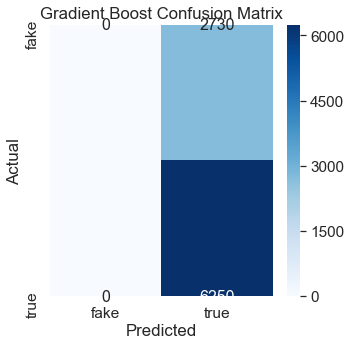

C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        fake       0.00      0.00      0.00      2730
        true       0.70      1.00      0.82      6250

    accuracy                           0.70      8980
   macro avg       0.35      0.50      0.41      8980
weighted avg       0.48      0.70      0.57      8980



In [26]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Gradient Boost classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Gradient Boost Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [27]:
from sklearn.metrics import f1_score
f1_GB = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_GB)

F1 score: 0.571234


C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# XGBoost Classifier

In [28]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=2020))])

model_XGB = pipe.fit(x_train, y_train)
prediction = model_XGB.predict(x_test)
acc_XGB = round(model_XGB.score(x_train, y_train)*80,20)
acc_XGB

56.21248399131355

Samples incorrectly classified: 2735 out of 8980.
XGBoost classifier accuracy: 56.94%


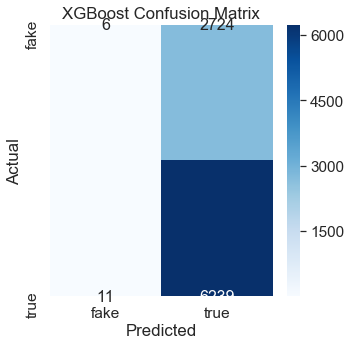

              precision    recall  f1-score   support

        fake       0.35      0.00      0.00      2730
        true       0.70      1.00      0.82      6250

    accuracy                           0.70      8980
   macro avg       0.52      0.50      0.41      8980
weighted avg       0.59      0.70      0.57      8980



In [29]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("XGBoost classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="XGBoost Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [30]:
from sklearn.metrics import f1_score
f1_XGB = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_XGB)

F1 score: 0.572194


# Stochastic Gradient Descent

In [31]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SGDClassifier())])

model_SGD = pipe.fit(x_train, y_train)
prediction = model_SGD.predict(x_test)
acc_SGD = round(model_SGD.score(x_train, y_train)*80,20)
acc_SGD

56.078846260927676

Samples incorrectly classified: 2730 out of 8980.
Stochastic Gradient Descent classifier accuracy: 56.94%


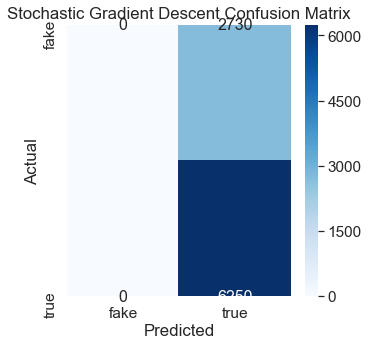

C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        fake       0.00      0.00      0.00      2730
        true       0.70      1.00      0.82      6250

    accuracy                           0.70      8980
   macro avg       0.35      0.50      0.41      8980
weighted avg       0.48      0.70      0.57      8980



In [32]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Stochastic Gradient Descent classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Stochastic Gradient Descent Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [33]:
from sklearn.metrics import f1_score
f1_SGD = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_SGD)

F1 score: 0.571234


C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Decision Tree

In [34]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=2020))])

model_DT = pipe.fit(x_train, y_train)
prediction = model_DT.predict(x_test)
acc_DT = round(model_DT.score(x_train, y_train)*80,20)
acc_DT

56.39734951834734

Samples incorrectly classified: 2760 out of 8980.
Decision Tree classifier accuracy: 56.94%


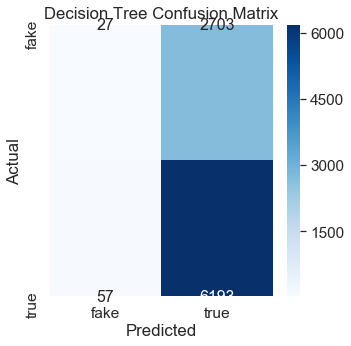

              precision    recall  f1-score   support

        fake       0.32      0.01      0.02      2730
        true       0.70      0.99      0.82      6250

    accuracy                           0.69      8980
   macro avg       0.51      0.50      0.42      8980
weighted avg       0.58      0.69      0.57      8980



In [35]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Decision Tree classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Decision Tree Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [36]:
from sklearn.metrics import f1_score
f1_DT = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_DT)

F1 score: 0.574997


# Random Forest Classifier

In [37]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=100))])

model_RF = pipe.fit(x_train, y_train)
prediction = model_RF.predict(x_test)
acc_RF = round(model_RF.score(x_train, y_train)*80,20)
acc_RF

76.36728102901053

Samples incorrectly classified: 2918 out of 8980.
Random Forest classifier accuracy: 56.94%


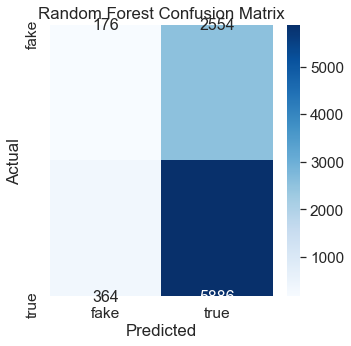

              precision    recall  f1-score   support

        fake       0.33      0.06      0.11      2730
        true       0.70      0.94      0.80      6250

    accuracy                           0.68      8980
   macro avg       0.51      0.50      0.45      8980
weighted avg       0.58      0.68      0.59      8980



In [38]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("Random Forest classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="Random Forest Confusion Matrix", figsize=(5,5))
print(classification_report(y_test, prediction))

In [39]:
from sklearn.metrics import f1_score
f1_RF = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_RF)

F1 score: 0.590466


# KNN Classifier

In [40]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'))])

model_KNN = pipe.fit(x_train, y_train)
prediction = model_KNN.predict(x_test)
acc_KNN = round(model_KNN.score(x_train, y_train)*80,20)
acc_KNN

76.36728102901053

Samples incorrectly classified: 3239 out of 8980.
KNN classifier accuracy: 56.94%


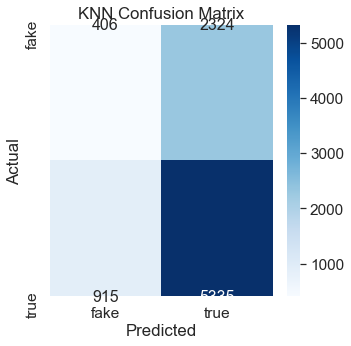

              precision    recall  f1-score   support

        fake       0.31      0.15      0.20      2730
        true       0.70      0.85      0.77      6250

    accuracy                           0.64      8980
   macro avg       0.50      0.50      0.48      8980
weighted avg       0.58      0.64      0.59      8980



In [41]:
print("Samples incorrectly classified: {0} out of {1}.".format((y_test != prediction).sum(),
                                                                len(y_test)))
print("KNN classifier accuracy: {0:.2f}%".format(model_log.score(x_train, y_train)*80,20))

plot_confusion_matrix(y_test, prediction, 
                      title="KNN Confusion Matrix", figsize=(5,5))

print(classification_report(y_test, prediction))

In [42]:
from sklearn.metrics import f1_score
f1_KNN = f1_score(y_test, prediction, average='weighted')
print('F1 score: %f' % f1_KNN)

F1 score: 0.594852


In [43]:
from sklearn.metrics import accuracy_score
acc = (accuracy_score(y_test,prediction))
print('Accuracy score: %f' % acc)

Accuracy score: 0.639310


In [44]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction))

[[ 406 2324]
 [ 915 5335]]


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

        fake       0.31      0.15      0.20      2730
        true       0.70      0.85      0.77      6250

    accuracy                           0.64      8980
   macro avg       0.50      0.50      0.48      8980
weighted avg       0.58      0.64      0.59      8980



# LSTM

In [46]:
X = newstot.text
Y = newstot.target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [47]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
max_words = 500
max_len = 75
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model
model = RNN()

In [48]:
from tensorflow.keras.utils import plot_model 
plot_model(model, to_file='model1.png')
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [49]:
model.fit(sequences_matrix,Y_train,batch_size=32,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

C:\Users\alina\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30530 samples, validate on 7633 samples
Epoch 1/5
30530/30530 [==============================] - 139s 5ms/step - loss: 0.6134 - accuracy: 0.7004 - val_loss: 0.6187 - val_accuracy: 0.6920
Epoch 2/5
30530/30530 [==============================] - 142s 5ms/step - loss: 0.6107 - accuracy: 0.7008 - val_loss: 0.6182 - val_accuracy: 0.6920
Epoch 3/5
30530/30530 [==============================] - 144s 5ms/step - loss: 0.6077 - accuracy: 0.7008 - val_loss: 0.6456 - val_accuracy: 0.6920


In [50]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Accuracy: {:0.2f}%'.format(accr[1]*100))

6735/6735 [==============================] - 9s 1ms/step
Accuracy: 70.56%


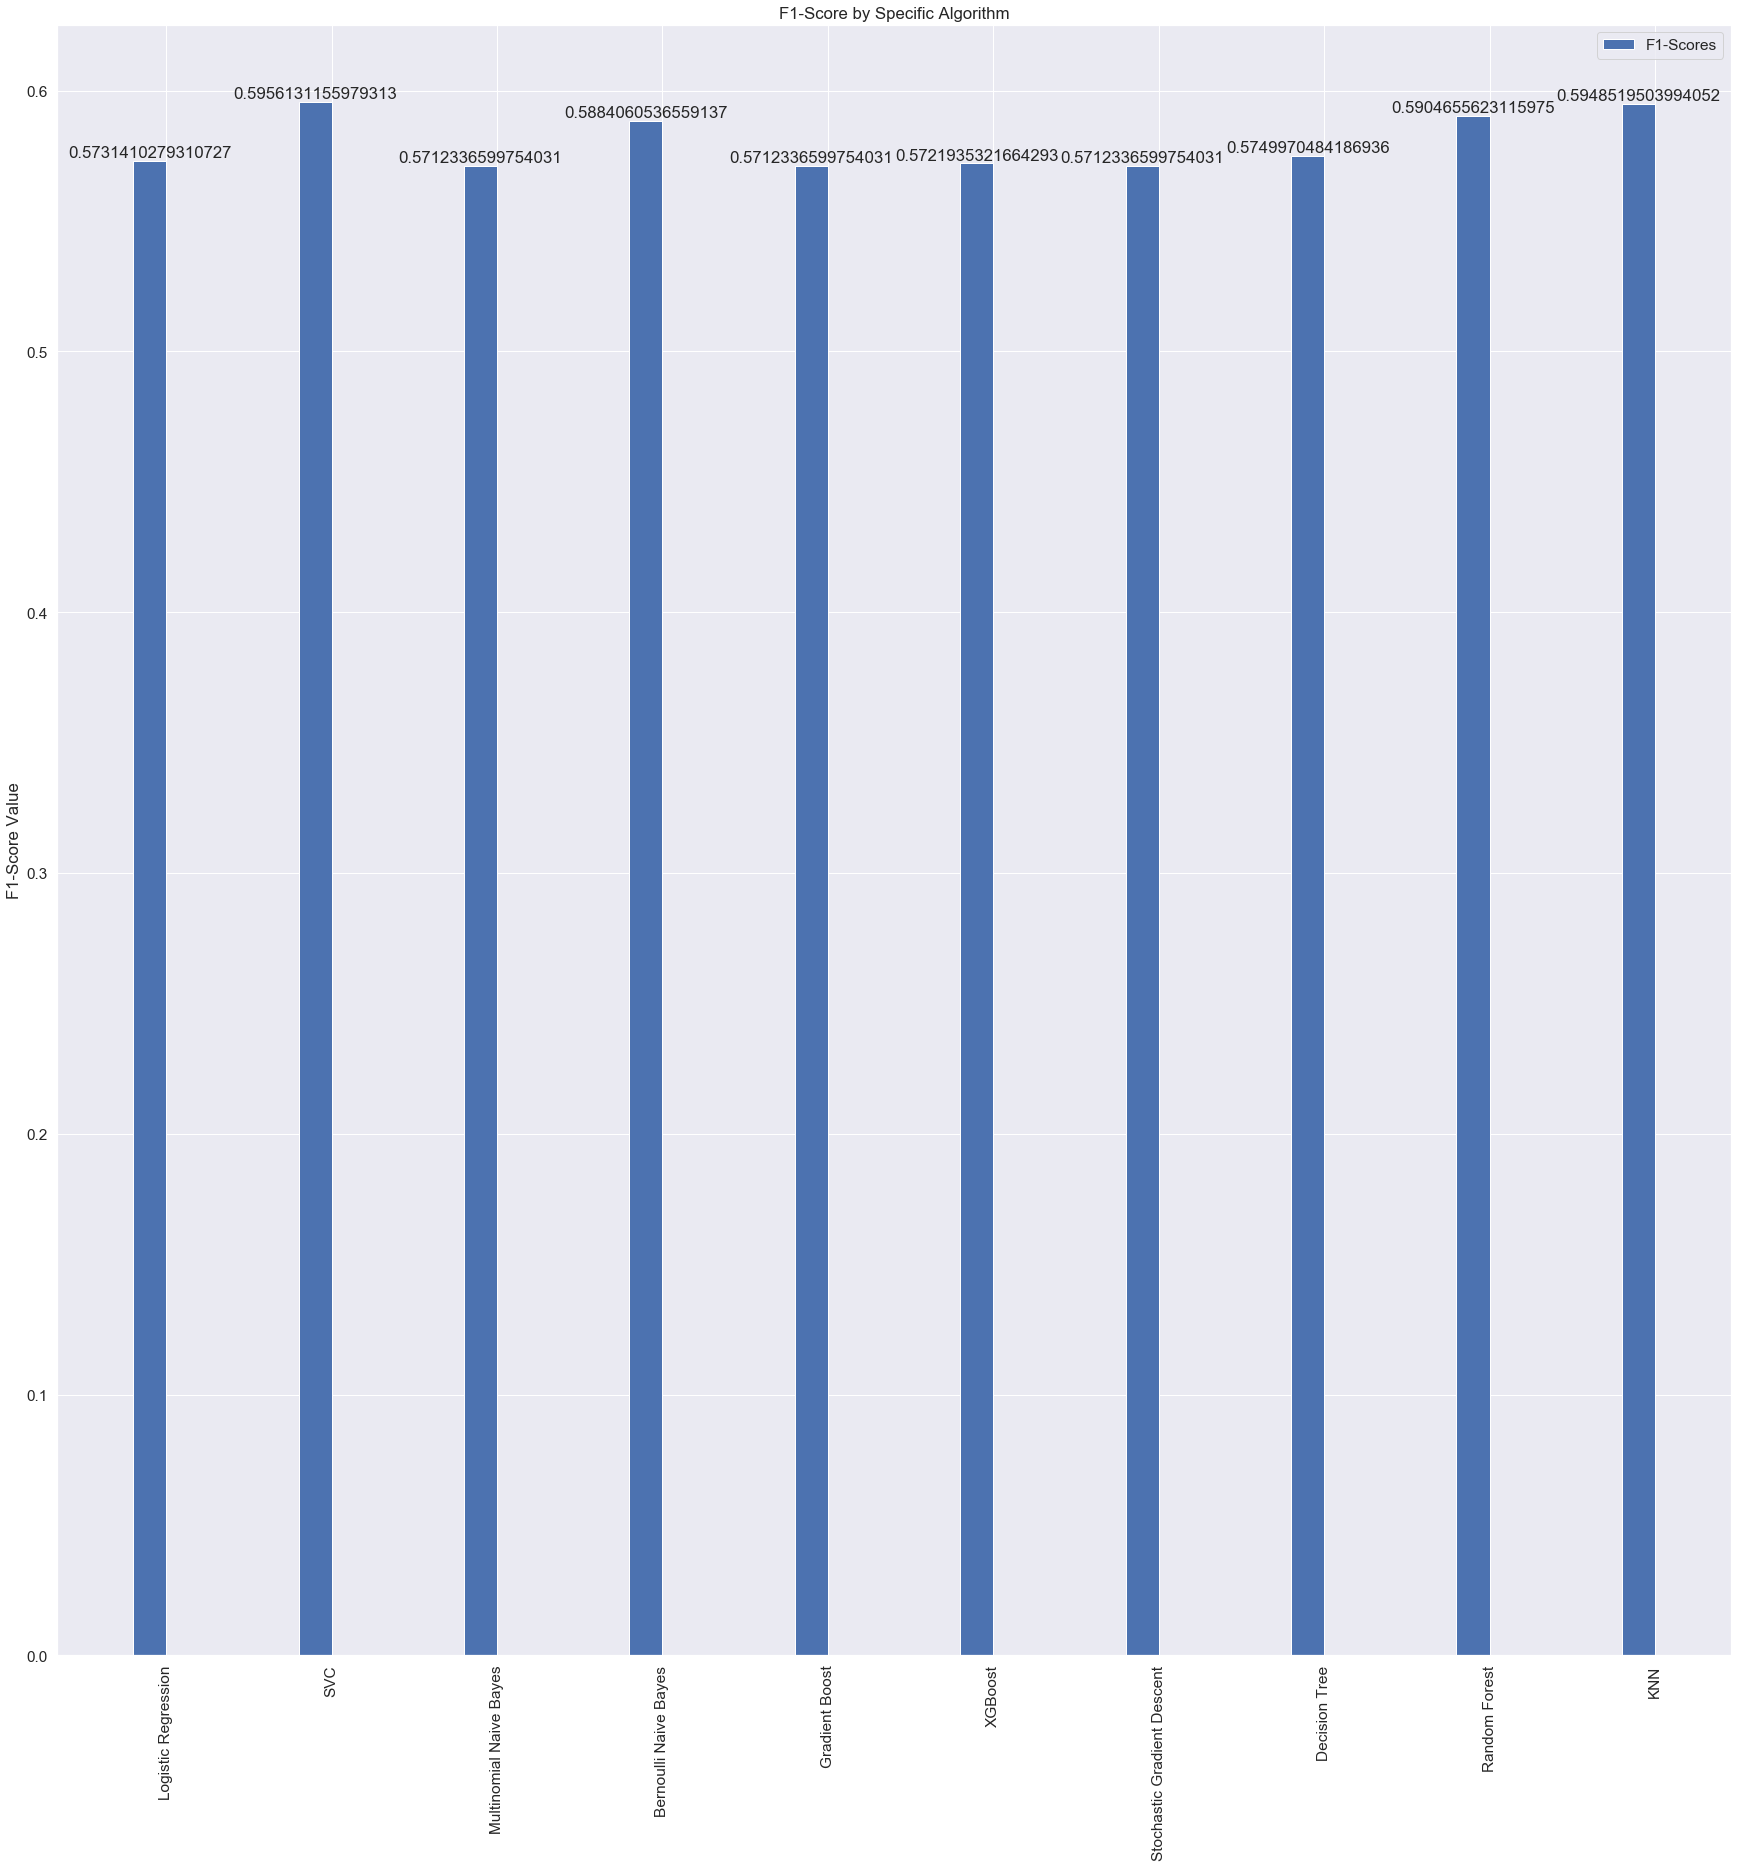

In [51]:
labels = ['Logistic Regression','SVC','Multinomial Naive Bayes','Bernoulli Naive Bayes','Gradient Boost','XGBoost','Stochastic Gradient Descent','Decision Tree', 'Random Forest', 'KNN']
fscores= [f1_LG, f1_SVC ,f1_MNB, f1_BNB ,f1_GB,f1_XGB, f1_SGD,f1_DT, f1_RF, f1_KNN]

x = np.arange(len(labels))  
width = 0.2 

fig, ax = plt.subplots(figsize=(30, 30))
rects1 = ax.bar(x - width/2, fscores, width, label='F1-Scores')

ax.set_ylabel('F1-Score Value')
ax.set_title('F1-Score by Specific Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0.5), 
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
plt.show()

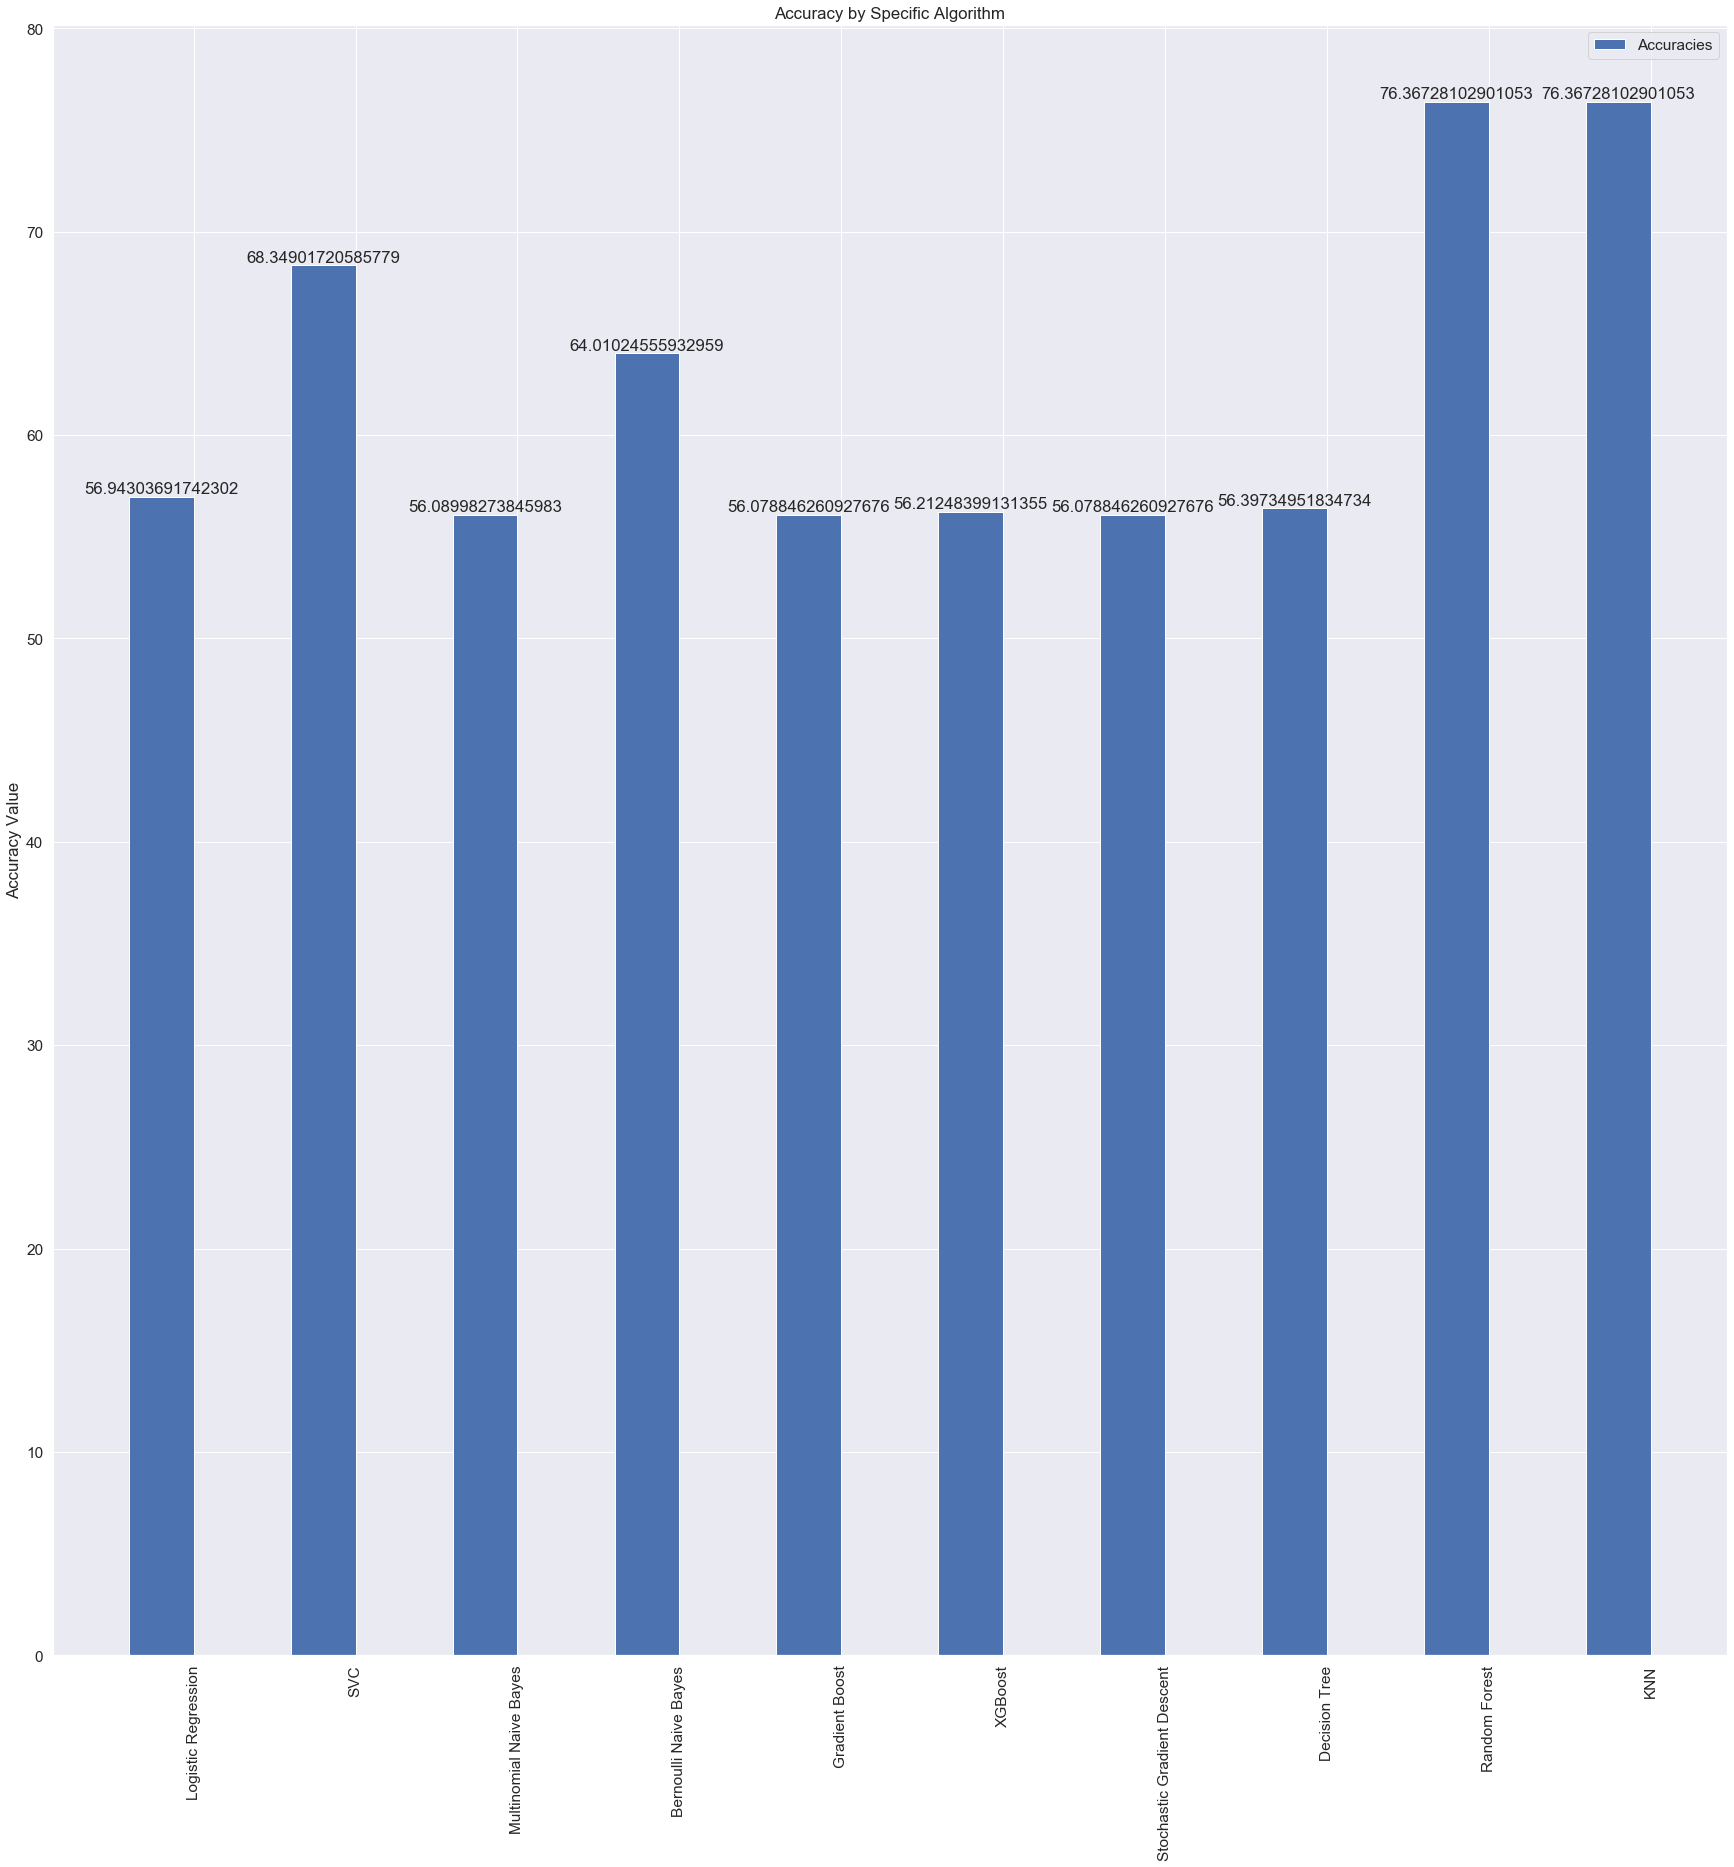

In [52]:
labels = ['Logistic Regression','SVC','Multinomial Naive Bayes','Bernoulli Naive Bayes','Gradient Boost','XGBoost','Stochastic Gradient Descent','Decision Tree', 'Random Forest', 'KNN']
fscores= [acc_LG, acc_SVC, acc_MNB, acc_BNB, acc_GB, acc_XGB, acc_SGD, acc_DT, acc_RF, acc_KNN]

x = np.arange(len(labels))  
width = 0.4 

fig, ax = plt.subplots(figsize=(30, 30))
rects1 = ax.bar(x - width/2, fscores, width, label='Accuracies')

ax.set_ylabel('Accuracy Value')
ax.set_title('Accuracy by Specific Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0.5),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
plt.show()